# SETI-Breakthrough Listen. EfficientNet-B4+Grad-CAM
We train 1 fold of EfficientNet-B4 with image size 768x768. It only uses Hflip, Vflip, and Mixup augmentation. It uses a cosine train schedule with warmup and 40 epochs. Using full precision, this takes 24 hours to train on 4xV100 Nvidia GPU. (Using mixed precision trains twice as fast but unfortunately hurts accuracy for this model).

This notebook also demonstrates Grad Cam to show us what image features the model is using to predict targets.

In [4]:
import sys
sys.path.append('/kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle')
! pip install -e /kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle

Obtaining file:///kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle
  Running setup.py develop for efficientnet
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python3.7 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle/setup.py'"'"'; __file__='"'"'/kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' develop --no-deps
         cwd: /kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle/
    Complete output (4 lines):
    running develop
    running egg_info
    creating efficientnet.egg-info
    error: could not create 'efficientnet.egg-info': Read-only file system
    -------------------

In [5]:
import cv2, os, gc, sys
from sklearn.metrics import roc_auc_score
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
import tensorflow as tf, math
import tensorflow.keras.backend as K
print('TF version',tf.__version__)
from tqdm import tqdm

TRAIN_MODEL = False
FOLD_0_ONLY = True
MODEL_PATH = '/kaggle/input/setieb4768model/'
# IF ONLY INTERESTED IN GRAD CAM, SET BELOW TO FALSE
PREDICT_OOF = True
PREDICT_TEST = True

TF version 2.4.1


In [6]:
os.environ

environ{'LC_ALL': 'C.UTF-8',
        'LD_LIBRARY_PATH': '/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/opt/conda/lib',
        'CUDA_MINOR_VERSION': '0',
        'KAGGLE_DATA_PROXY_TOKEN': 'eyJhbGciOiJBMTI4S1ciLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0.EVew3LjzoIw619g52vhRSvGKs8ILPYtOn09ol5qkaVi_B2aenL3V7g.-dBYJARg-ACTEezZDigVSA.2b9Pz-UZt9zQp0BSoP-KlkkEbadDhNOWyTwiDR6DdABsEsRJBBLrWbaOm_cSkPqIVSfUAW3De8BzzAQudCnBvp_RtfuXAQki31pERdi4MjylDfCUJeRa40j2Wo1RUFY95zf4k3frU9z45kyYUlwPpIYSep4fzzMRsOXviz45BqasEgvpFjOJQqvESOitG4IqNgQGR56tvGpb4TofzbHNiW0-GnGFWKFDv51Wh2t6_3QxuyuW5FwvCkm8SJD45Wtfzpdz-S5vAefrhd3XzRVhXl6oTt_WOfyJkZM-ZKgoaXg.v4O3zVMF9vn-bphrzxIGrQ',
        'LANG': 'C.UTF-8',
        'LD_LIBRARY_PATH_NO_STUBS': '/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/opt/conda/lib',
        'HOSTNAME': 'ea6ab27c8385',
        'TESSERACT_PATH': '/usr/bin/tesseract',
        'KAGGLE_KERNEL_INTEGRATIONS': '',
        'NVIDIA_VISIBLE_DEVICES': 'all',
        'PROJ_LIB': '/opt/conda/share/proj',
        'KAGGLE

In [ ]:
# LIST GPUS TO BE USED
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# EXPERIMENT VERSION NUMBER
VER = 1003

In [ ]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

# Load Train and Test

In [ ]:
train = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
print('Train shape is', train.shape )
train.head()

In [ ]:
test = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')
print('Test shape is', test.shape )
test.head()

# Data Loader

In [ ]:
SIZE = 768
BASE = '../input/seti-breakthrough-listen/train/'

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=32, shuffle=False, augment=False, visualize=False, size=SIZE, path=BASE,
                 flipH=False, flipV=False, mixup_prob=0, mixup_alpha=3, mixup_max=True): 

        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mixup_prob = mixup_prob
        self.mixup_alpha = mixup_alpha
        self.mixup_max = mixup_max
        self.visualize = visualize
        self.size = size
        self.path = path
        self.flipH = flipH
        self.flipV = flipV
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.df) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        
        if self.augment: X = self.__augment_batch(X)                       
        if self.flipH: X = X[:,::-1,:,:]
        if self.flipV: X = X[:,:,::-1,:]
            
        return X,y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.df ) )
        if self.shuffle: np.random.shuffle(self.indexes)
            
    def _get_image(self,row):
        data = np.load(self.path+row.id[0]+'/'+row.id+'.npy').astype('float32') 
        X = np.zeros((273*3,256),dtype='float32')
        
        for k in range(3):
            if self.visualize:
                md = np.median(data[2*k,].flatten())
                q75, q25 = np.percentile(data[2*k,].flatten(), [75 ,25])
                iqr = q75 - q25
                tmp = np.clip(data[2*k,],md-2*iqr,md+2*iqr)
                tmp -= md-2*iqr
                tmp /= 4*iqr
            else: 
                tmp = data[2*k,]       
            X[273*k:273*(k+1),] = tmp
            
        X = cv2.resize(X,(self.size,self.size))
                               
        return X,float(row.target)
        
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),self.size,self.size,1),dtype='float32')
        y = np.zeros((len(indexes)),dtype='float32')
        
        df = self.df.loc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            X[i,:,:,0],y[i] = self._get_image(row)
                                
        # MIXUP WITHIN BATCH
        y2 = y.copy(); X2 = X.copy()
        for i in range(len(indexes)):
            if np.random.uniform(0,1) < self.mixup_prob:
                rw = np.random.randint(0,len(indexes),2)
                img,tar = X2[rw[0],], y2[rw[0]]  
                img2,tar2 = X2[rw[1],], y2[rw[1]]
                w = np.random.beta(self.mixup_alpha,self.mixup_alpha)
                X[i,] = w * img2 + (1-w) * img
                if self.mixup_max:
                    y[i] = np.max([tar,tar2])
                else:
                    y[i] = w * tar2 + (1-w) * tar
                    
        return X,y
 
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            #albu.ShiftScaleRotate(rotate_limit=0,scale_limit=0.125,shift_limit=0.0625,p=0.25), 
            #albu.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0, p=0.25),
        ])
        return composition(image=img)
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            tmp = self.__random_transform(img_batch[i, ])
            img_batch[i, ] = tmp['image']
        return img_batch

# Display Examples
When displaying example, we use the flag `visualize=True`. We do not use this during training, but when displaying images, this flag makes the colors easier for us to see with our human eye.

In [ ]:
# DISPLAY EXAMPLES OF DATALOADER
cols = 4
train_gen = DataGenerator(train, augment=True, shuffle=True, batch_size=4, visualize=True, mixup_prob=1.0)
# i - номер батча
# b - сам батч
for i,b in enumerate(train_gen):
    plt.figure(figsize=(20,10))
    for k in range(cols):
        plt.subplot(1,cols,k+1)
        plt.imshow( b[0][k] ) 
        t = b[1][k]
        plt.title('target = %i'%t,size=16)
    plt.show()
    if i>=3: break
       

# Models
In the model below we can use `tf.keras.layers.Concatenate` instead of `tf.keras.layers.Conv2D` and we can remove `tf.keras.layers.Dropout(0.15)` and achieve the same model performance. So they are not important. The most important thing is mixup augmentation, large image size, and large backbone.

In [ ]:
def build_model():

    inp = tf.keras.layers.Input(shape=(None,None,1))
    x = tf.keras.layers.Conv2D(3,3,strides=1,padding='same')(inp)
    base = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=None)
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Dense(1, activation='relu', dtype='float32')(x)
        
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    met = tf.keras.metrics.AUC()
    loss = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(loss=loss, optimizer=opt, metrics=met) 
        
    return model

In [ ]:
def build_cam_model():

    inp = tf.keras.layers.Input(shape=(None,None,1))
    x = tf.keras.layers.Conv2D(3,3,strides=1,padding='same')(inp)
    base = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=None)
    x0 = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x0)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(x)
        
    model = tf.keras.Model(inputs=inp, outputs=[x,x0])
        
    return model

# Learning Schedule

In [ ]:
LR_START = 5e-5
LR_MAX = 5e-4
LR_MIN = 5e-7
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 40

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Train Model

In [ ]:
FOLDS = 5
BATCH = 32
EPOCHS = 40
BATCH_SIZE = 32
VAL_BATCH = 32 #make this larger offline

FOLDS = 5
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
train['fold'] = -1
oof = np.zeros(len(train))
preds = np.zeros(len(test))

for fold,(idx_t, idx_v) in enumerate(skf.split(train)):
    if (not TRAIN_MODEL)&(not PREDICT_OOF)&(not PREDICT_TEST): break
        
    K.clear_session()
    print('#'*25)
    print('### FOLD',fold+1)
    print('### train size',len(idx_t),'valid size',len(idx_v))
    print('#'*25)
    
    train_gen = DataGenerator(train.iloc[idx_t], shuffle=True, augment=True, batch_size=BATCH, mixup_prob=1.0)
    valid_gen = DataGenerator(train.iloc[idx_v], batch_size=VAL_BATCH) 
    test_gen = DataGenerator(test, batch_size=VAL_BATCH, path='../input/seti-breakthrough-listen/test/')
    
    sv = tf.keras.callbacks.ModelCheckpoint(
        'model_fold%i_v%i.h5'%(fold,VER), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch'
    )
    
    with strategy.scope():
        model = build_model()  
    if TRAIN_MODEL:
        model.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, verbose=1, callbacks=[sv,lr_callback]
             ,use_multiprocessing=True, workers=4)
               
    if PREDICT_OOF | PREDICT_TEST:
        print('Loading model to predict oof and preds...')
        model.load_weights(MODEL_PATH+'model_fold%i_v%i.h5'%(fold,VER))
    
    if PREDICT_OOF:
        print('Predicting oof with TTAx4...')
        oof[idx_v] += model.predict(valid_gen,verbose=1).flatten()/4.
        valid_gen = DataGenerator(train.iloc[idx_v], batch_size=VAL_BATCH, flipH=True) 
        oof[idx_v] += model.predict(valid_gen,verbose=1).flatten()/4.
        valid_gen = DataGenerator(train.iloc[idx_v], batch_size=VAL_BATCH, flipV=True) 
        oof[idx_v] += model.predict(valid_gen,verbose=1).flatten()/4.
        valid_gen = DataGenerator(train.iloc[idx_v], batch_size=VAL_BATCH, flipH=True, flipV=True) 
        oof[idx_v] += model.predict(valid_gen,verbose=1).flatten()/4.
    
        auc = roc_auc_score(train.target.values[idx_v],oof[idx_v])
        print(f'Fold {fold+1} AUC =',auc)
        print('wrote OOF to disk')
        print('#'*25)
    
        # SAVE EACH OOF IN CASE WE STOP TRAINING EARLY
        train.loc[idx_v,'fold'] = fold
        train['oof'] = oof
        train.to_csv(f'oof_v{VER}_f{fold}.csv',index=False)  
    
        # LOG FOLD OOF AUC SCORE
        f = open(f'log_v{VER}.txt','a')
        f.write(f'Fold {fold+1} AUC = {auc}\n')
        f.close()
        
    if PREDICT_TEST:    
        print('Predicting test with TTAx4...')
        preds += model.predict(test_gen,verbose=1).flatten()/FOLDS/4
        test_gen = DataGenerator(test, batch_size=VAL_BATCH, path='../input/seti-breakthrough-listen/test/',flipH=True)
        preds += model.predict(test_gen,verbose=1).flatten()/FOLDS/4
        test_gen = DataGenerator(test, batch_size=VAL_BATCH, path='../input/seti-breakthrough-listen/test/',flipV=True)
        preds += model.predict(test_gen,verbose=1).flatten()/FOLDS/4
        test_gen = DataGenerator(test, batch_size=VAL_BATCH, path='../input/seti-breakthrough-listen/test/',flipH=True,flipV=True)
        preds += model.predict(test_gen,verbose=1).flatten()/FOLDS/4
    
        # SAVE EACH TEST IN CASE WE STOP TRAINING EARLY
        test['target'] = preds*5/(fold+1)
        test.to_csv(f'submission_v{VER}_f{fold}.csv',index=False)
        print('wrote submission to disk')
        
    del model, train_gen, valid_gen, test_gen, sv
    _ = gc.collect()
    
    if FOLD_0_ONLY: break

# Grad Cam OOF Preds

In [ ]:
# LOAD WEIGHTS INTO GRAD CAM MODEL
FOLDS = 5
fold = 0
with strategy.scope():
    model = build_cam_model()    
model.load_weights(MODEL_PATH+'model_fold%i_v%i.h5'%(fold,VER))
layer_weights = model.layers[-1].get_weights()[0][:,0]

In [ ]:
# HELPER FUNCTION
def mask2contour(mask, width=5):
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

clahe = cv2.createCLAHE(clipLimit=16.0, tileGridSize=(8,8))

In [ ]:
# GET OOF WITH TARGET EQUAL 1
PORTION = 512
tmp = train.iloc[idx_v[:PORTION]]
tmp = tmp.reset_index(drop=True)
IDX = tmp.loc[tmp.target==1].index.values
len(IDX)

In [ ]:
# PREDICT OOF SAMPLES FOR GRAD CAM
valid_gen = DataGenerator(train.iloc[idx_v[IDX]], batch_size=VAL_BATCH)
p,x = model.predict(valid_gen,verbose=1)
print(x.shape)

In [ ]:
SKIP = 0
SHOW = 32

for i,k in enumerate(IDX[SKIP:SKIP+SHOW]):
    
    plt.figure(figsize=(20,5))
    
    # PLOT GRAD CAM
    img = np.sum(x[i+SKIP,] * layer_weights,axis=-1)
    img = cv2.resize(img,(320,320))
    plt.subplot(1,4,4)
    plt.imshow(img)
    
    # GET GRAD CAM CONTOUR
    cut = np.percentile(img.flatten(), [90])[0]
    cntr = img.copy()
    cntr[cntr>=cut] = 100
    cntr[cntr<cut] = 0
    cntr = mask2contour(cntr)

    # PLOT ORIGINAL ON CADENCE
    name = train.iloc[idx_v[k],0]
    tar = train.iloc[idx_v[k],1]
    img0 = np.load(BASE+name[0]+'/'+name+'.npy').astype('float32')
    img = np.vstack(img0[::2])
    img = cv2.resize(img,(320,320))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title(f'Train ID = {name}',size=14)
        
    # PLOT ON CADENCE WITH IMPROVED VISIBILITY FILTER
    plt.subplot(1,4,2)
    img = img[1:,1:] - img[:-1,:-1] #emboss
    img -= np.min(img)
    img /= np.max(img)
    img = (img*255).astype('uint8')
    img = cv2.GaussianBlur(img,(5,5),0)
    img = clahe.apply(img)
    mx = np.max(img)
    if p[i+SKIP,0]>0.5: 
        cntr = cntr[1:,1:]
        img[cntr>0] = mx
    plt.imshow(img)
    plt.title(f'True = {tar}',size=14)
    
    # PLOT OFF CADENCE WITH IMPROVED VISIBILITY
    img = np.vstack(img0[1::2])
    img = cv2.resize(img,(320,320))
    plt.subplot(1,4,3)  
    img = img[1:,1:] - img[:-1,:-1] #emboss
    img -= np.min(img)
    img /= np.max(img)
    img = (img*255).astype('uint8')
    img = cv2.GaussianBlur(img,(5,5),0)
    img = clahe.apply(img)
    plt.imshow(img)
    plt.title(f'Pred = {p[i+SKIP,0]:.3}',size=14)
    
    plt.show()

# Grad Cam Test Preds

In [ ]:
# PREDICT OOF SAMPLES FOR GRAD CAM
PORTION = 256
test_gen = DataGenerator(test.iloc[:PORTION], batch_size=VAL_BATCH, path='../input/seti-breakthrough-listen/test/')
p,x = model.predict(test_gen,verbose=1)
print(x.shape)

In [ ]:
# FIND PREDICTIONS WITH TARGET EQUAL 1
IDX = np.where(p>0.75)[0]
len(IDX)

In [ ]:
SKIP = 0
SHOW = 32
BASE2 = '../input/seti-breakthrough-listen/test/'

for i,k in enumerate(IDX[SKIP:SKIP+SHOW]):
    
    plt.figure(figsize=(20,5))
    
    # PLOT GRAD CAM
    img = np.sum(x[k,] * layer_weights,axis=-1)
    img = cv2.resize(img,(320,320))
    plt.subplot(1,4,4)
    plt.imshow(img)
    
    # GET GRAD CAM CONTOUR
    cut = np.percentile(img.flatten(), [90])[0]
    cntr = img.copy()
    cntr[cntr>=cut] = 100
    cntr[cntr<cut] = 0
    cntr = mask2contour(cntr)

    # PLOT ORIGINAL ON CADENCE
    name = test.iloc[k,0]
    img0 = np.load(BASE2+name[0]+'/'+name+'.npy').astype('float32')
    img = np.vstack(img0[::2])
    img = cv2.resize(img,(320,320))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title(f'Test ID = {name}',size=14)
        
    # PLOT ON CADENCE WITH IMPROVED VISIBILITY FILTER
    plt.subplot(1,4,2)
    img = img[1:,1:] - img[:-1,:-1] #emboss
    img -= np.min(img)
    img /= np.max(img)
    img = (img*255).astype('uint8')
    img = cv2.GaussianBlur(img,(5,5),0)
    img = clahe.apply(img)
    mx = np.max(img)
    if p[k,0]>0.5: 
        cntr = cntr[1:,1:]
        img[cntr>0] = mx
    plt.imshow(img)
    #plt.title(f'True = {tar}',size=14)
    
    # PLOT OFF CADENCE WITH IMPROVED VISIBILITY
    img = np.vstack(img0[1::2])
    img = cv2.resize(img,(320,320))
    plt.subplot(1,4,3)  
    img = img[1:,1:] - img[:-1,:-1] #emboss
    img -= np.min(img)
    img /= np.max(img)
    img = (img*255).astype('uint8')
    img = cv2.GaussianBlur(img,(5,5),0)
    img = clahe.apply(img)
    plt.imshow(img)
    plt.title(f'Pred = {p[k,0]:.3}',size=14)
    
    plt.show()

### Explanation the Leak in Data

In [7]:
INPUT_DIR = "../input/seti-breakthrough-listen"
df_train = pd.read_csv(os.path.join(INPUT_DIR, "train_labels.csv"))
df_subm = pd.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))
df_train_pos = df_train[df_train.target == 1]

Functions for loading and displating samples of data:

In [8]:
def load_example(idx):
    try:
        x = np.load(os.path.join(INPUT_DIR, "train", idx[0], idx + ".npy"))
    except:
        x = np.load(os.path.join(INPUT_DIR, "test",  idx[0], idx + ".npy"))
    return x.astype(np.float32)


def show_example(x, p=0):
    
    x = x.reshape(-1, 256)
    x = np.clip(x, np.percentile(x, p), np.percentile(x, 100-p)) # clip for better contrast
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 3)
    ax.set_xticks(np.arange(1,6)*273)
    ax.set_yticks([])
    ax.grid(True)
    ax.imshow(x.T, aspect="auto", cmap="Greys")

Let's take a look at one sample which contains a needle with a vety low SNR, definitely not visible by eye, the 5th positive sample in train. Time is the horizontal direction, frequency vertical:

004933b94083be2


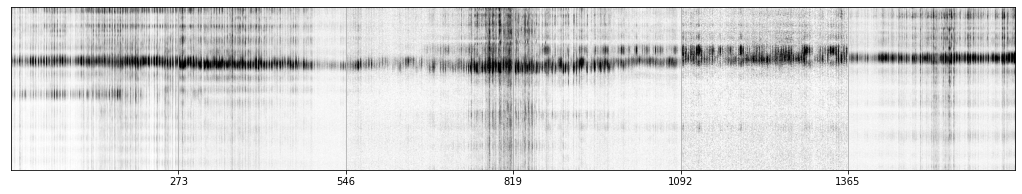

In [9]:
idx = df_train_pos.id.iloc[5]
print(idx)
x0 = load_example(idx)
show_example(x0, 1)

Let's doing the "renormalization". We start with one normalized reference column and check if this column is found somewhere else in the data:

In [10]:
def column_norm(x):
    ''' normalizes each column of 273 pixels in each of the 6 images in sample x separately 
    to mean==0 and L2 norm==1 '''
    
    xn  = x - np.mean(x, axis=1, keepdims=True) # remove mean
    xn /= np.sqrt(np.sum(xn**2, axis=1, keepdims=True)) # normalize
    return xn  

def find_similar_column(col0, xn1):
    ''' calculates cosine similarity between the normalized reference column col0 and all columns
        in the column-normalized sample xn1 '''
    
    return np.array([ [ np.dot(col0, col1) for col1 in img.T ] for img in xn1 ])

The normalized sample from above. Still no needle visible.

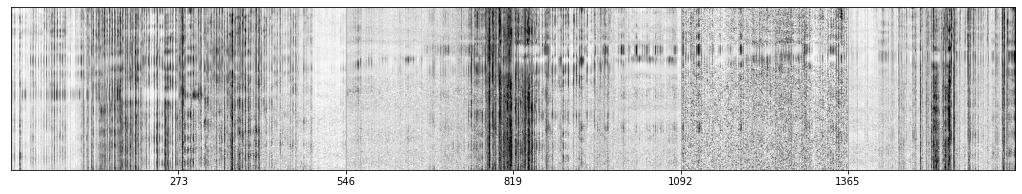

In [11]:
xn0 = column_norm(x0)
show_example(xn0, 1)

Now let's search the dataset for a copy of normalized column 128 in image 1 of our sample. I use col 128 because it's in the middle of the image. I search only a small subset of the full 60,000 samples dataset to keep running time short because I know from earlier runs where the match will be ;).

In [12]:
for idx in tqdm(df_train.id.iloc[50500:51000]):
    xn1 = column_norm(load_example(idx))
    cs = find_similar_column(xn0[0,:,128], xn1)
    csm = cs.max()
    if csm > 0.9:
        print(idx, csm, cs.argmax() % 273)

 74%|███████▍  | 371/500 [00:12<00:03, 40.25it/s]

d87cb86179e9d02 0.9999998 68


100%|██████████| 500/500 [00:15<00:00, 32.06it/s]


Found a perfect match: sample d87cb86179e9d02. Let's look at it. It is identical to 004933b94083be2  where they overlap It's only shifted by 128-68=60 frequency bins:

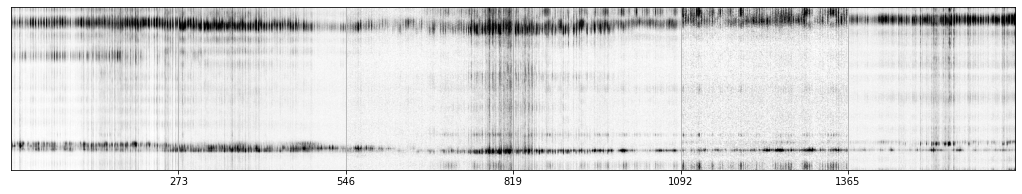

In [13]:
x1 = load_example("d87cb86179e9d02")
show_example(x1, 1)

Normalize it and subtract from the normalized sample xn0. Increasing the contrast a little, the needles are easily visible. The noise has been perfectly removed because of the leak.

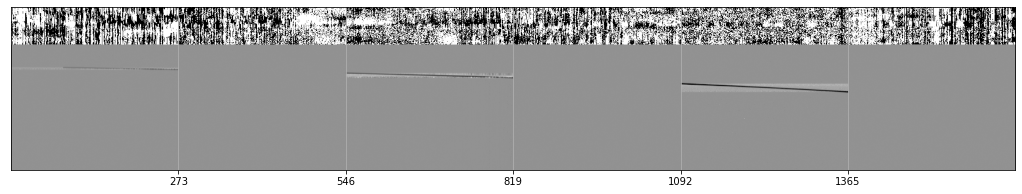

In [16]:
xn1 = column_norm(x1)
show_example(xn0 - np.roll(xn1, 128-68, axis=2), 10)

Increasing the contrast some more, numerical rounding errors become visible, except for where the artificial signals were inserted. Obviously using rectangles.

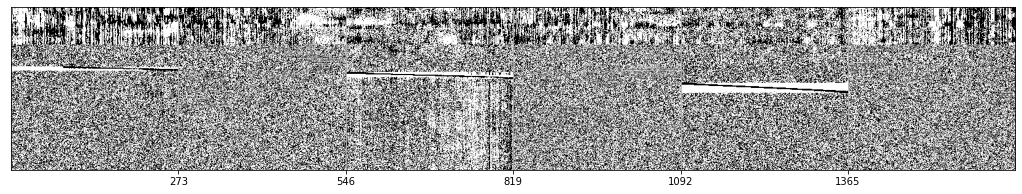

In [18]:
show_example(xn0 - np.roll(xn1, 128-68, axis=2), 40)